# А/Б тесты. Статистические тесты

Сайт запустил A/B-тест с целью узнать какой экран чекаута принесет больше прибыли. 
А/Б-тесты — один из мощнейших инструментов для проверки гипотез, которые используются большими компаниями. 
При анализе и проведении эксперимента могут возникнуть различные трудности. 
В этом наборе данных и анализе приведены несколько типичных проблемных случаев из реальной жизни.

##  Содержание
- _Загрузка и очистка_ 
- _Статистический анализ_ 
- _Выводы_ 

##  __Загрузка и очистка__ 

In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
# загружаем датафрейм
df = pd.read_csv(r"C:\Users\josep\Desktop\AB\AB_Test_Results.csv")
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [3]:
# идентификая выбросов
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [4]:
# проверка незаполненных значений
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [5]:
# кол-во в тесте и контроле
df.value_counts(df['VARIANT_NAME'])

VARIANT_NAME
variant    5016
control    4984
dtype: int64

In [6]:
# кол-во уникальных значений
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [7]:
# типы данных
df.dtypes

USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object

In [8]:
# проверяем все ли данные уникальны, нет ли дубликатов
print (df.shape[0] == df['USER_ID'].nunique)

False


In [9]:
# смотрим сколько дубликатов и уникальных
double_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_count

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [10]:
# в относительных единицах
double_count / double_count.sum()

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64

In [11]:
# Пользователей, которые имеют 2 группы мы убираем т.к. их всего 24%
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
single_variant_users = single_variant_users[single_variant_users]

In [12]:
df = df[df['USER_ID'].isin(single_variant_users.index)]
# кол-во в тесте и контроле
df.value_counts(df['VARIANT_NAME'])

VARIANT_NAME
variant    3044
control    3026
dtype: int64

In [13]:
# Посмотрим как распределены наши данные теперь

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

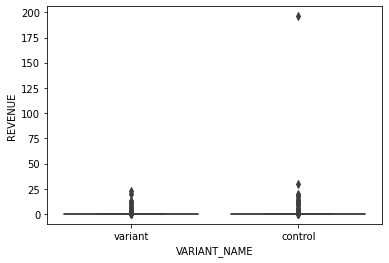

In [14]:
sns.boxplot(data = df, y = df['REVENUE'], x = df['VARIANT_NAME'])

In [15]:
# видим что наши ящики `сплющены`, следовательно в данных есть выбросы
df.sort_values(by='REVENUE', ascending=False).head(10)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


In [16]:
# Пользователь 3342 сильно отличается от других, удалим 
df = df.drop(1437)

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

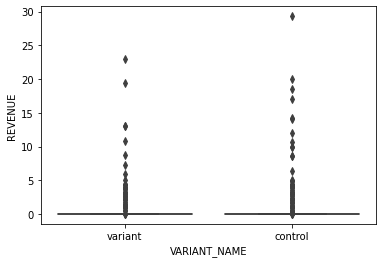

In [17]:
# видим что графики все еще не читаемы, 
# это происходит потому что очень много людей ничего не покупали
sns.boxplot(data = df, y = df['REVENUE'], x = df['VARIANT_NAME'])

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

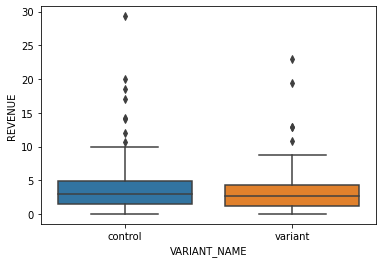

In [18]:
sns.boxplot(data = df[df['REVENUE'] > 0], y = 'REVENUE' , x = 'VARIANT_NAME')

In [19]:
# мы видим что некоторые user_id дублируются
df.value_counts('USER_ID').head(10)

USER_ID
5652    6
1782    5
1339    5
8536    4
8357    4
1007    4
1184    4
5095    4
6414    4
543     4
dtype: int64

_Один и тот же пользователь в нашем датасете может иметь множество записей с разным чеком. Сгруппируем и просуммируем по каждому пользователю._

In [20]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

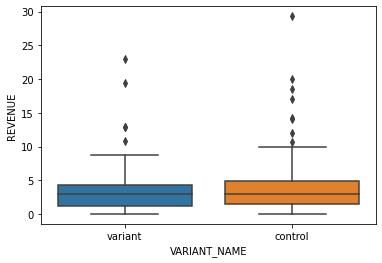

In [21]:
sns.boxplot(data = df[df['REVENUE'] > 0], y = 'REVENUE' , x = 'VARIANT_NAME')

In [22]:
# узнаем метрики по группам
all_stats = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

all_stats

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control         2389  274.55  0.114923    0.0  2389
variant         2393  179.32  0.074935    0.0  2393

In [23]:
# метрики по платящим пользователям
paid_stat = df.loc[df.REVENUE != 0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                                                     'REVENUE': ['sum', 'mean', 'median', 'count']})

paid_stat

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control           53  274.55  5.180189   2.99    53
variant           42  179.32  4.269524   2.97    42

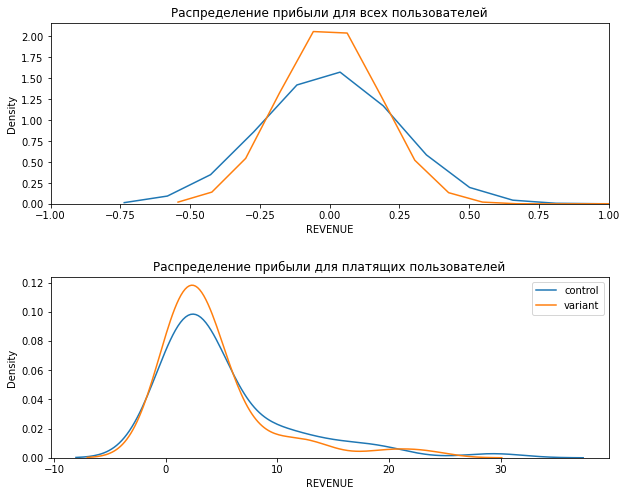

In [24]:
f, axes = plt.subplots(2, figsize=(10,8))
sns.kdeplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control' ) 
sns.kdeplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_xlim([-1, 1]) 
axes[0].set_title('Распределение прибыли для всех пользователей')

# строим графики для платящих пользователей
sns.kdeplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.kdeplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Распределение прибыли для платящих пользователей')
plt.legend()
plt.subplots_adjust(hspace = 0.4)

##  __Статистический анализ__ 

In [25]:
ss.shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=0.06145977973937988, pvalue=0.0)

_Нулевая гипотеза о нормальности распределения отклонена_

In [26]:
# Посмотрим сколько у нас нулевых значений в графе Revenue
(df['REVENUE'] == 0).value_counts()

True     4687
False      95
Name: REVENUE, dtype: int64

### Тест Манна-Уитни

In [27]:
# для всех пользователей
ss.mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'],
              df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

_pval > 0.05 мы не можем отклонить нулевую гипотезу(о том что средние не отличаются)_

In [28]:
ss.mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'], 
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=1029.0, pvalue=0.5314192217084708)

_pval > 0.05 мы не можем отклонить нулевую гипотезу_

### Бутстрэп

In [29]:
# скачиваем библиотеку с помощью !pip
!pip install bootstrapped

In [30]:
# импортируем необходимые модули
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

Также нам понадобятся аргументы:


- `stat_func = bs_stats.mean` — что мы хотим исследовать. В нашем случае — среднее значение

- `compare_func = bs_compare.difference` — как мы хотим исследовать. В нашем случае — хотим взять разницу между группами

- `return_distribution = True` — вернем набор разниц, который функция получает в результате всех итераций

In [31]:
# Для всех пользователей
control = df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values
variant = df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values

In [32]:
# Для платящих пользователей
control_paid = df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values
variant_paid = df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values

In [33]:
# для всех
boot_results = bs.bootstrap_ab(test = variant, ctrl = control
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)

In [34]:
#  для платящих пользователей
boot_results_paid = bs.bootstrap_ab(test = variant_paid, ctrl = control_paid
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)

In [35]:
borders = np.percentile(boot_results, [2.5, 97.5]) # считаем перцентили
borders

array([-0.09932242,  0.01764378])

In [36]:
borders_paid = np.percentile(boot_results_paid, [2.5, 97.5]) # считаем перцентили
borders_paid

array([-3.13168014,  1.27582761])

c:\Users\josep\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


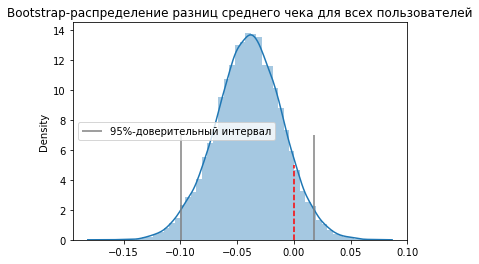

In [37]:
sns.distplot(boot_results) 
plt.title('Bootstrap-распределение разниц среднего чека для всех пользователей')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, # отрисуем линию на уровне нуля
           ymin = 0, 
           ymax = 5, 
           linestyles= '--', 
           colors = 'red')
plt.vlines(borders, # отрисуем перцентили
           ymin = 0, 
           ymax = 7, 
           linestyles= '-', 
           colors = 'grey', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()

c:\Users\josep\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


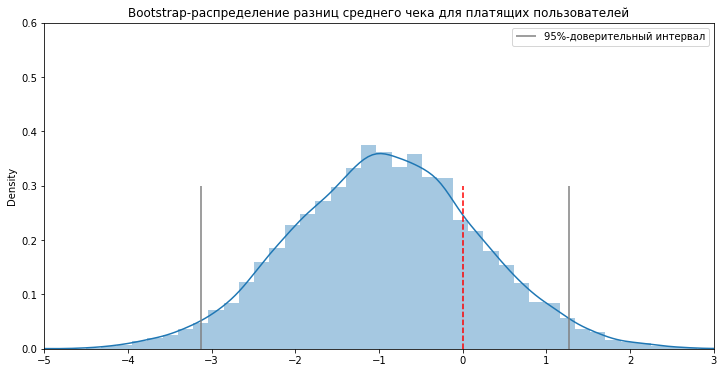

In [38]:
sns.distplot(boot_results_paid) 
plt.title('Bootstrap-распределение разниц среднего чека для платящих пользователей')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, # отрисуем линию на уровне нуля
           ymin = 0, 
           ymax = 0.3, 
           linestyles= '--', 
           colors = 'red')
plt.vlines(borders_paid, # отрисуем перцентили
           ymin = 0, 
           ymax = 0.3, 
           linestyles= '-', 
           colors = 'grey', 
           label = '95%-доверительный интервал')
plt.ylim(0, 0.6)
plt.xlim(-5, 3)
plt.legend()
plt.show()

##  __Выводы__ 

- Мы произвели загрузку и очистку данных. Удалили выбросы, дубликаты и пустые значения, отсекли нулевые значения для того, чтобы результаты были корректнее.
- На основе тестов Манна - Уитни и бутстрэп мы можем сделать вывод, что статистически значимой разницы между выборками нет.